# Text classification using BERT & Tensorflow

+ Submit date: march 31, 2023

## Load dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import pickle

In [2]:
# Takes 1-2 minutes to load 
df_og = pd.read_csv('amazon_reviews_multilingual_US_v1_00-001.tsv', sep='\t', header=0, on_bad_lines='skip')

## Preparing the Dataset and DataModule

In [3]:
# reset the data if desired (rather than importing from scratch)
df_1 = df_og.copy()

# all five categories
categories = ['Shoes', 'Home', 'Kitchen','Toys', 'Electronics'] 

# three categories
#categories = ['Shoes', 'Home', 'Kitchen'] #We can change the categories - 'Toys', 'Electronics',
#df_1 = df_1.sample(frac=0.1, replace=False, random_state=1)
df_1 = df_1[df_1['product_category'].isin(categories)]

# Missing values
df_1 = df_1.dropna()

print(df_1['product_category'].value_counts())
print('-------')
print('Shape:', df_1.shape)
print('-------')
print('Features:', df_1.columns)

Toys           57456
Electronics    11421
Shoes           7342
Home            1998
Kitchen         1834
Name: product_category, dtype: int64
-------
Shape: (80051, 15)
-------
Features: Index(['marketplace', 'customer_id', 'review_id', 'product_id',
       'product_parent', 'product_title', 'product_category', 'star_rating',
       'helpful_votes', 'total_votes', 'vine', 'verified_purchase',
       'review_headline', 'review_body', 'review_date'],
      dtype='object')


/tmp/ipykernel_961/275576359.py:5: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


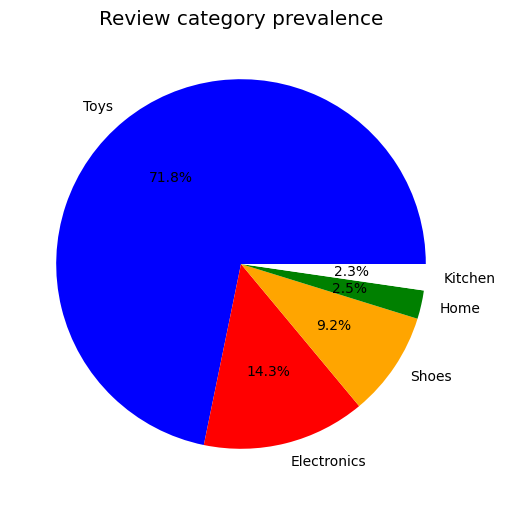

In [4]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 6))
y = df_1['product_category'].value_counts().values / len(df_1) * 100
ax.pie(y, colors=['blue', 'red', 'orange', 'green', 'white'], autopct='%1.1f%%', labels=['Toys',  'Electronics', 'Shoes', 'Home', 'Kitchen']) #
ax.set_title('Review category prevalence')
fig.show()

For the purpose of classification, we need numeric labels. Therefore, we map the topics descriptions to integers as follows:

## Class imbalance

In [5]:
df_1 = df_1[['review_body', 'product_category']]
df_1

,review_body,product_category
28949,While this is the sleek 90's version of the ch...,Toys
32892,I loved it when my children first received thi...,Toys
33568,my daughter can beat this phone up and it stil...,Toys
33746,It is so wonderful to see a childhood favorite...,Toys
34450,Do you need to use your phone but can't pry it...,Toys
...,...,...
6900671,Amps aren't supposed to make headphones sound ...,Electronics
6900805,If you have played the other ticket to ride ga...,Toys
6900820,very good quality one of the best looking blad...,Toys
6900822,one of the best battle tops made very solid an...,Toys


In [6]:
df_toys = df_1[df_1['product_category']=='Toys']
df_toys.shape

(57456, 2)

In [7]:
df_not_toys = df_1[df_1['product_category']!='Toys']
df_not_toys.shape

(22595, 2)

In [8]:
# set a subsample of size category 1 (electronics)
df_toys_downsampled = df_toys.sample(df_1[df_1['product_category']=='Electronics'].shape[0])
df_toys_downsampled.shape

(11421, 2)

In [9]:
df_balanced = pd.concat([df_toys_downsampled, df_not_toys])
df_balanced.shape

(34016, 2)

/tmp/ipykernel_961/2492327138.py:5: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


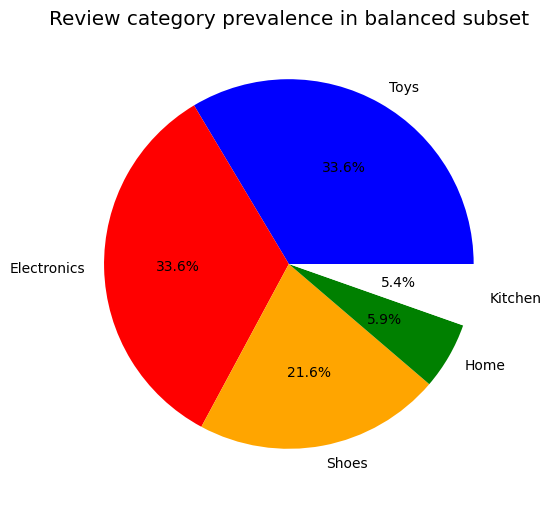

In [10]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 6))
y = df_balanced['product_category'].value_counts().values / len(df_balanced) * 100
ax.pie(y, colors=['blue', 'red', 'orange', 'green', 'white'], autopct='%1.1f%%', labels=['Toys',  'Electronics', 'Shoes', 'Home', 'Kitchen']) #
ax.set_title('Review category prevalence in balanced subset')
fig.show()

For the purpose of classification, we need numeric labels. Therefore, we map the topics descriptions to integers. 

In [12]:
df_balanced['product_category_num'] = df_balanced['product_category'].map({'Toys': 0,
                                                             'Electronics': 1,
                                                             'Kitchen': 2,
                                                             'Home': 3,
                                                             'Shoes': 4})
labels = np.zeros((len(df_balanced), len(df_balanced['product_category_num'].unique())))
labels[np.arange(len(df_balanced)), df_balanced['product_category_num'].values] = 1

## Split in Train, Test and also validation datasets

In [13]:
from sklearn.model_selection import train_test_split

RANDOM_SEED = 2000

# First Split for Train and Test
x_train,x_test,y_train,y_test = train_test_split(df_balanced['review_body'], labels, test_size=0.25, random_state=RANDOM_SEED,shuffle=True)

# Next split Train in to training and validation
x_tr,x_val,y_tr,y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=RANDOM_SEED,shuffle=True)

In [14]:
print(x_tr.shape,'\n', 
      y_tr.shape,'\n', 
      x_val.shape,'\n', 
      y_val.shape)

(20409,) 
 (20409, 5) 
 (5103,) 
 (5103, 5)


## Data modeling

Load BERT with TensorFlow Hub

In [15]:
#!pip install tensorflow
#!pip install tensorflow-text
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text  # Registers the ops.

preprocessor = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3")


def get_embeddings(sentences):
  '''return BERT-like embeddings of input text
  Args:
    - sentences: list of strings
  Output:
    - BERT-like embeddings: tf.Tensor of shape=(len(sentences), 768)
  '''
  preprocessed_text = preprocessor(sentences)
  return encoder(preprocessed_text)['pooled_output']

2023-03-31 23:18:25.994000: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-31 23:18:26.335690: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-03-31 23:18:26.335705: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-03-31 23:18:27.215834: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

## Observe semantic textual similarities

In [16]:
get_embeddings([
    "As a somewhat shy child, this toy gave me a great  way to learn to chat"]
)

<tf.Tensor: shape=(1, 768), dtype=float32, numpy=
array([[-0.7447648 , -0.35582486, -0.46742484,  0.37933972,  0.4213218 ,
        -0.03902478,  0.7030207 ,  0.07828838, -0.32768214, -0.9998222 ,
        -0.20347548,  0.78032786,  0.97909135,  0.07953237,  0.9362603 ,
        -0.3130581 ,  0.44408816, -0.4455129 ,  0.15517654,  0.14137901,
         0.6634576 ,  0.9990459 ,  0.4430892 ,  0.28041247,  0.31033525,
         0.8531966 , -0.5931164 ,  0.92992485,  0.9466001 ,  0.6677754 ,
        -0.2901023 ,  0.06179081, -0.9887543 ,  0.00774501, -0.4461563 ,
        -0.98210406,  0.22754382, -0.6907635 ,  0.05587851,  0.18954684,
        -0.90426385,  0.18102117,  0.9996615 , -0.59740514,  0.16833879,
        -0.15085642, -0.99994063,  0.2555511 , -0.82949865,  0.6333104 ,
         0.52301913,  0.7513579 , -0.01232042,  0.32466155,  0.3478977 ,
         0.08994178, -0.33846247, -0.05786791, -0.11337137, -0.45360643,
        -0.6508891 ,  0.23274375, -0.43332583, -0.78399336,  0.58882636,
 

Due to the nature of the model, we can effectively estimate the semantic similarity between sentences in different quotes.

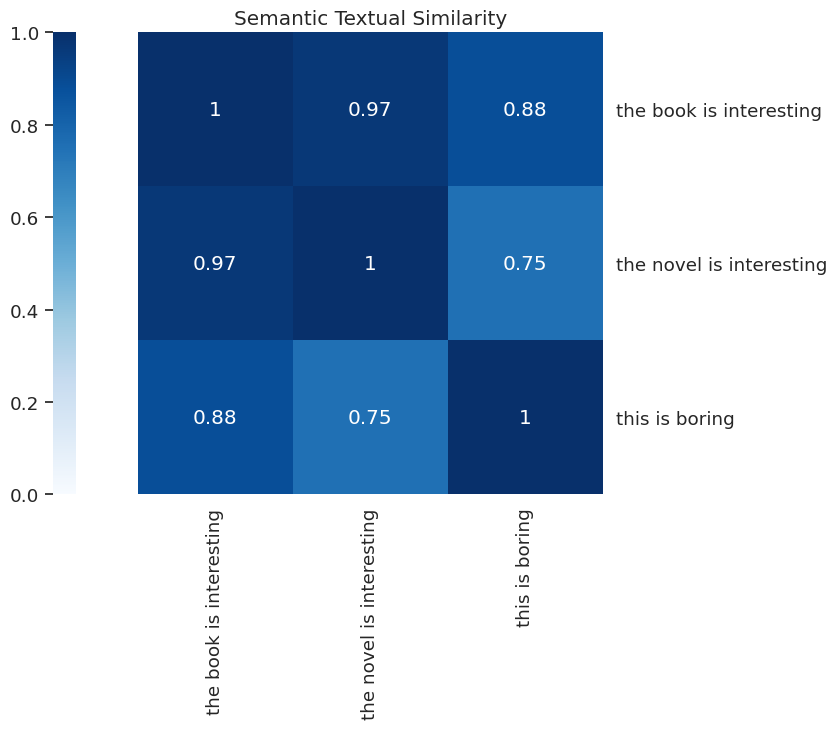

In [17]:
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity


def plot_similarity(features, labels):
  """Plot a similarity matrix of the embeddings."""
  cos_sim = cosine_similarity(features)
  fig = plt.figure(figsize=(8,6))
  sns.set(font_scale=1.2)
  cbar_kws=dict(use_gridspec=False, location="left")
  g = sns.heatmap(
      cos_sim, xticklabels=labels, yticklabels=labels,
      vmin=0, vmax=1, annot=True, cmap="Blues", 
      cbar_kws=cbar_kws)
  g.tick_params(labelright=True, labelleft=False)
  g.set_yticklabels(labels, rotation=0)
  g.set_title("Semantic Textual Similarity")

reviews = ["the book is interesting",
            "the novel is interesting",
            "this is boring"]

plot_similarity(get_embeddings(reviews), reviews)

## Classification Model
As we are facing a multi-class classification problem, and we previously noticed that our topics distribution is slightly imbalanced, 
we define functions to calculate, respectively, `precision`, `recall`, and `F1 score` for each class during training, and then 
return the average value over the classes.

In [18]:
from keras import backend as K

def balanced_recall(y_true, y_pred):
    """This function calculates the balanced recall metric
    recall = TP / (TP + FN)
    """
    recall_by_class = 0
    # iterate over each predicted class to get class-specific metric
    for i in range(y_pred.shape[1]):
        y_pred_class = y_pred[:, i]
        y_true_class = y_true[:, i]
        true_positives = K.sum(K.round(K.clip(y_true_class * y_pred_class, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true_class, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        recall_by_class = recall_by_class + recall
    return recall_by_class / y_pred.shape[1]

def balanced_precision(y_true, y_pred):
    """This function calculates the balanced precision metric
    precision = TP / (TP + FP)
    """
    precision_by_class = 0
    # iterate over each predicted class to get class-specific metric
    for i in range(y_pred.shape[1]):
        y_pred_class = y_pred[:, i]
        y_true_class = y_true[:, i]
        true_positives = K.sum(K.round(K.clip(y_true_class * y_pred_class, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred_class, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        precision_by_class = precision_by_class + precision
    # return average balanced metric for each class
    return precision_by_class / y_pred.shape[1]

def balanced_f1_score(y_true, y_pred):
    """This function calculates the F1 score metric"""
    precision = balanced_precision(y_true, y_pred)
    recall = balanced_recall(y_true, y_pred)
    return 2 * ((precision * recall) / (precision + recall + K.epsilon()))

We now define a model as the `preprocessor` and `encoder` layers followed by a `dropout` and a `dense` layer with a `softmax` activation function and an output space dimensionality equal to the number of classes we want to predict.

In [19]:
i = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
x = preprocessor(i)
x = encoder(x)
x = tf.keras.layers.Dropout(0.1, name="dropout")(x['pooled_output'])
x = tf.keras.layers.Dense(5, activation='softmax', name="output")(x)

model = tf.keras.Model(i, x)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


+ Once we have defined the model’s structure, we can compile and fit it. 
+ We choose to train the model for **20 epochs**, but we also use the `EarlyStopping` callback in order to monitor the validation loss during training: if the metric does not improve for at least 3 epochs (patience = 3), the training is interrupted and the weights from the epoch where the validation loss showed the best value (i.e. lowest) are restored (restore_best_weights = True).

In [20]:
n_epochs = 20

METRICS = [
      tf.keras.metrics.CategoricalAccuracy(name="accuracy"),
      balanced_recall,
      balanced_precision,
      balanced_f1_score
]

earlystop_callback = tf.keras.callbacks.EarlyStopping(monitor = "val_loss", 
                                                      patience = 3,
                                                      restore_best_weights = True)

model.compile(optimizer = "adam",
              loss = "categorical_crossentropy",
              metrics = METRICS)

model_fit = model.fit(x_tr, 
                      y_tr, 
                      epochs = n_epochs,
                      validation_data = (x_val, y_val),
                      callbacks = [earlystop_callback])

Epoch 1/20
638/638 [==============================] - 1618s 3s/step - loss: 1.1791 - accuracy: 0.5571 - balanced_recall: 0.1738 - balanced_precision: 0.3694 - balanced_f1_score: 0.2295 - val_loss: 0.9998 - val_accuracy: 0.6837 - val_balanced_recall: 0.2926 - val_balanced_precision: 0.5021 - val_balanced_f1_score: 0.3662
Epoch 2/20
638/638 [==============================] - 1575s 2s/step - loss: 0.9578 - accuracy: 0.6799 - balanced_recall: 0.3403 - balanced_precision: 0.4936 - balanced_f1_score: 0.3996 - val_loss: 0.8823 - val_accuracy: 0.7061 - val_balanced_recall: 0.3746 - val_balanced_precision: 0.5064 - val_balanced_f1_score: 0.4288
Epoch 3/20
638/638 [==============================] - 1610s 3s/step - loss: 0.8732 - accuracy: 0.7026 - balanced_recall: 0.3847 - balanced_precision: 0.5006 - balanced_f1_score: 0.4331 - val_loss: 0.8069 - val_accuracy: 0.7415 - val_balanced_recall: 0.4164 - val_balanced_precision: 0.5256 - val_balanced_f1_score: 0.4627
Epoch 4/20
638/638 [==============

We can finally plot the values assumed by each monitored metric during the training procedure, and compare the training and validation curves:

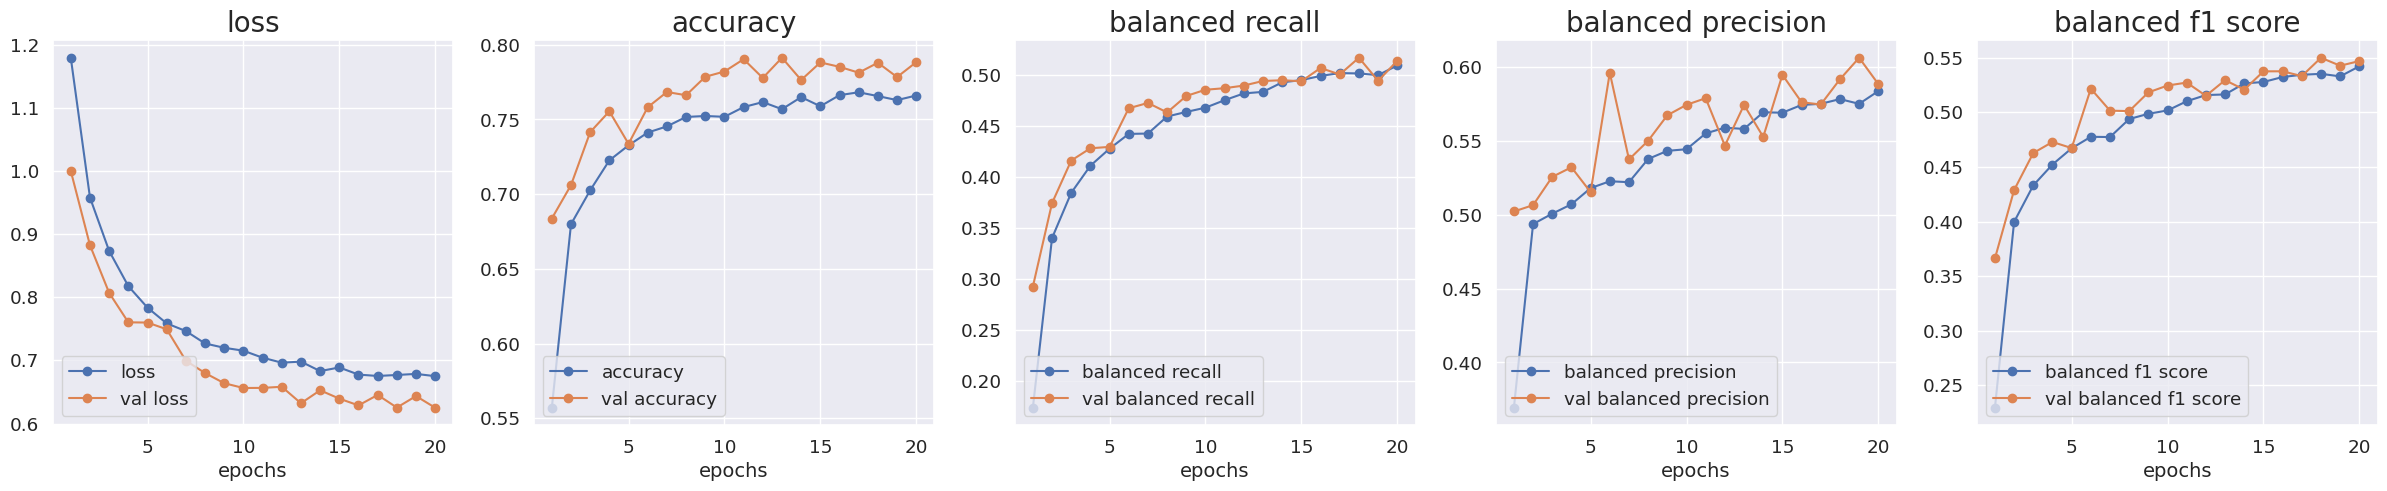

In [21]:
x = list(range(1, n_epochs+1))
metric_list = list(model_fit.history.keys())
num_metrics = int(len(metric_list)/2)

fig, ax = plt.subplots(nrows=1, ncols=num_metrics, figsize=(30, 5))

for i in range(0, num_metrics):
  ax[i].plot(x, model_fit.history[metric_list[i]], marker="o", label=metric_list[i].replace("_", " "))
  ax[i].plot(x, model_fit.history[metric_list[i+num_metrics]], marker="o", label=metric_list[i+num_metrics].replace("_", " "))
  ax[i].set_xlabel("epochs",fontsize=14)
  ax[i].set_title(metric_list[i].replace("_", " "),fontsize=20)
  ax[i].legend(loc="lower left")

## Prediction: blind set evaluation

+ In order to fairly estimate our performances, we evaluate the quality of the predictions on a new dataset containing observations that were not “seen” by the model during training (blind set).
+ By following the same steps used to prepare the training and validation sets, we can map topic descriptions to numeric labels and inspect some random samples.

In [22]:
def predict_class(reviews):
  '''predict class of input text
  Args:
    - reviews (list of strings)
  Output:
    - class (list of int)
  '''
  return [np.argmax(pred) for pred in model.predict(reviews)]

y_pred = predict_class(x_test)

266/266 [==============================] - 527s 2s/step


In [23]:
def find_position_of_one(list_of_lists):
    positions = []
    for lst in list_of_lists:
        positions.append(lst.index(1))
    return positions

y_test_f = y_test.tolist()
y_test_f = find_position_of_one(y_test_f)

We can now test the blind set performances.

In [24]:
from sklearn.metrics import classification_report


y_pred = predict_class(x_test)
print(classification_report(y_test_f, y_pred))

266/266 [==============================] - 520s 2s/step
              precision    recall  f1-score   support

           0       0.73      0.90      0.81      2786
           1       0.77      0.90      0.83      2877
           2       0.88      0.31      0.46       493
           3       0.69      0.10      0.18       484
           4       0.94      0.77      0.84      1864

    accuracy                           0.79      8504
   macro avg       0.80      0.60      0.62      8504
weighted avg       0.80      0.79      0.77      8504



## Save and load the model for future use

We might want to save the model and load it as needed for future predictions.

In [25]:
#model.save("./models/gilBERTo_v1/")
#new_model = keras.models.load_model("./models/gilBERTo_v1/")